# 利用MindQuantum解决组合优化问题

In [166]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
Looking in links: https://obs-workspace-20180810.obs.cn-north-1.myhuaweicloud.com/pypi/index.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [167]:
import networkx as nx

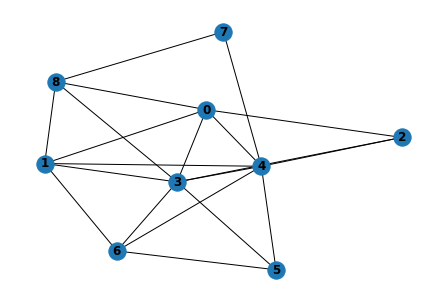

In [168]:
g = nx.gnm_random_graph(9, 20, seed=42)
nx.draw(g,with_labels=True, font_weight='bold')

In [169]:
print(list(g.edges))

[(0, 1), (0, 8), (0, 2), (0, 4), (0, 3), (1, 8), (1, 6), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (3, 8), (3, 6), (3, 5), (4, 7), (4, 5), (4, 6), (5, 6), (7, 8)]


## nx库中的解法

In [170]:
cut, partition = nx.algorithms.approximation.one_exchange(g)
print(cut, partition)

14 ({8, 3, 4}, {0, 1, 2, 5, 6, 7})


## Try to solve by yourself

In [171]:
def solution(edges):
    pass

In [172]:
my_cut = solution(list(g.edges))
print(f'I get {my_cut} cuts')

I get None cuts


## QAOA

In [173]:
from mindquantum import *

In [174]:
depth = 3
ansatz = MaxCutAnsatz(list(g.edges), depth)

ham = ansatz.hamiltonian
circuit = ansatz.circuit
circuit

q0: ──H────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)─────────────────────────────────────────────────────────────ZZ(beta_1)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)─────────────────────────────────────────────────────────────ZZ(beta_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │             │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │
q1: ──H────ZZ(beta_0)────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)────ZZ(beta_1)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)────ZZ(beta_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                             │             │             │             │              │             │             │             │                                                                                                                                                                             │             │             │             │              │             │             │             │                                                                                                                                                                             │             │             │             │              │             │             │             │
q2: ──H──────────────────────┼─────────ZZ(beta_0)────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────ZZ(beta_1)────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────ZZ(beta_2)────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                             │                           │             │              │             │             │             │              │             │                  

In [175]:
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(-ham), circuit)

In [176]:
import numpy as np

grad_ops(np.random.random(size=len(circuit.params_name)))

(array([[-10.08104914+3.00443821e-17j]]),
 array([[[-0.17225523+0.j,  0.282135  +0.j, -0.12902289+0.j,
           0.27478117+0.j, -0.11356832+0.j,  0.14584   +0.j]]]))

### 利用`scipy`的优化器进行优化

In [177]:
from scipy.optimize import minimize

def fun(x):
    f, g = grad_ops(x)
    print(f"Cut value: {-f.real[0, 0]}")
    return f.real[0, 0], g.real[0, 0]

np.random.seed(1)
x0 = np.random.random(len(circuit.params_name))
optimizers = ['cg', 'COBYLA', 'Powell', 'bfgs']
opti = optimizers[2]
tol = 1e-6
res = minimize(fun, x0, method=opti, jac=True, tol=tol)

Cut value: 7.359574310741286
Cut value: 8.851406021401965
Cut value: 10.54669022797708
Cut value: 9.920566388589535
Cut value: 10.54669022797708
Cut value: 9.997158874970722
Cut value: 10.047673372699943
Cut value: 9.498720328159084
Cut value: 10.547076745156337
Cut value: 10.278467143259395
Cut value: 10.472854919610374
Cut value: 10.556530781353139
Cut value: 10.557337801737937
Cut value: 10.557338797559808
Cut value: 10.557331954970884
Cut value: 10.557338797559808
Cut value: 6.8121118229667275
Cut value: 7.276295923208249
Cut value: 10.557338797559808
Cut value: 11.243444020769736
Cut value: 10.007493065167514
Cut value: 11.397284969976878
Cut value: 11.397129595974796
Cut value: 11.397306523185573
Cut value: 11.397306515305669
Cut value: 11.397306512610678
Cut value: 11.397306523185573
Cut value: 10.815423718769175
Cut value: 10.418655802666652
Cut value: 11.397306523185573
Cut value: 11.243501543519221
Cut value: 8.98431135548269
Cut value: 12.016544630010676
Cut value: 12.013657

In [178]:
def get_partitions(theta, first_n=1):
    s = Simulator('projectq', circuit.n_qubits)
    s.apply_circuit(circuit, dict(zip(circuit.params_name, theta)))
    state = s.get_qs()
    amp = np.abs(state)**2
    partitions=[]
    for n in range(first_n):
        poi = np.argmax(amp)
        amp[poi] = -1
        bin_string = bin(poi)[2:].zfill(circuit.n_qubits)[::-1]
        partition = [[], []]
        for i, j in enumerate(bin_string):
            partition[int(j)].append(i)
        partitions.append(partition)
    return partitions

def get_cut_value(graph, partitions):
    values = []
    for partition in partitions:
        value = 0
        for p0 in partition[0]:
            for p1 in partition[1]:
                for g in graph:
                    if p0 in g and p1 in g:
                        value += 1
        values.append(value)
    return values

In [179]:
partitions = get_partitions(res.x, 6)
for i, j in enumerate(partitions):
    print(f'partition {i}: {j}')

partition 0: [[1, 2, 4, 5, 8], [0, 3, 6, 7]]
partition 1: [[0, 3, 6, 7], [1, 2, 4, 5, 8]]
partition 2: [[0, 1, 2, 5, 6, 7], [3, 4, 8]]
partition 3: [[3, 4, 8], [0, 1, 2, 5, 6, 7]]
partition 4: [[0, 1, 3, 5, 7], [2, 4, 6, 8]]
partition 5: [[2, 4, 6, 8], [0, 1, 3, 5, 7]]


In [180]:
cut_values = get_cut_value(g.edges, partitions)
print(f'cut values: {cut_values}')
print(f'\nYour configuration:\ndepth: {depth}\nmethod: {opti}\ntol: {tol}\nstep: {res.nfev}')

cut values: [14, 14, 14, 14, 14, 14]

Your configuration:
depth: 3
method: Powell
tol: 1e-06
step: 503
